# Visualizing convnet filters

In [ ]:
# Listing 9.12 Instantiating the Xception convolutional base
model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False) 

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
# Listing 9.13 Printing the names of all convolutional layers in Xception
for layer in model.layers:
  if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
    print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


In [ ]:
# Listing 9.14 Creating a feature extractor model
layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

In [ ]:
# Listing 9.6 Preprocessing a single image
from tensorflow import keras 
import numpy as np
 
# download a test image
img_path = keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

def get_img_array(img_path, target_size):
  # open the image and resize it
  img = keras.utils.load_img(img_path, target_size=target_size)
  # turn image to numpy array (180,180,3)
  array = keras.utils.img_to_array(img)
  # add batch dimension (1,180,180,3)
  array = np.expand_dims(array, axis=0)
  return array
 
img_tensor = get_img_array(img_path, target_size=(180, 180))

In [ ]:
# Listing 9.15 Using the feature extractor
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)

In [ ]:
# define a function that returns a scalar value quantifying 
  # how much a given input image “activates” a given filter in the layer

import tensorflow as tf
 
def compute_loss(image, filter_index):
  activation = feature_extractor(image)
  # discard the first two pixels along the sides of the activation.
  filter_activation = activation[:, 2:-2, 2:-2, filter_index]
  return tf.reduce_mean(filter_activation)

In [ ]:
# Listing 9.16 Loss maximization via stochastic gradient ascent
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
      # Explicitly watch the image tensor, since it isn’t a TensorFlow Variable
      tape.watch(image)
      #  Compute the loss scalar, indicating how much the current image activates the filter.
      loss = compute_loss(image, filter_index)
    # Compute the gradients of the loss with respect to the image.
    grads = tape.gradient(loss, image)
    # Apply the “gradient normalization trick.”
    grads = tf.math.l2_normalize(grads)
    # Move the image a little bit in a direction that activates our target filter more strongly.
    image += learning_rate * grads
    # Return the updated image so we can run the step function in a loop.
    return image

In [ ]:
# Listing 9.17 Function to generate filter visualizations
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
  # Number of gradient ascent steps to apply
  iterations = 30
  # Amplitude of a single step
  learning_rate = 10.
  image = tf.random.uniform(
      minval=0.4,
      maxval=0.6,
      # Initialize an image tensor with random values
      shape=(1, img_width, img_height, 3))
  # Repeatedly update the values of the image tensor so as to maximize our loss function.
  for i in range(iterations):
    image = gradient_ascent_step(image, filter_index, learning_rate)
  return image[0].numpy()

In [ ]:
# Listing 9.18 Utility function to convert a tensor into a valid image
def deprocess_image(image):
  image -= image.mean()
  image /= image.std()
  image *= 64
  image += 128
  image = np.clip(image, 0, 255).astype("uint8")
  image = image[25:-25, 25:-25, :]
  return image

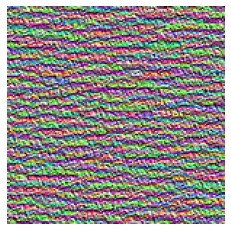

In [ ]:
# plot
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

In [ ]:
# Listing 9.19 Generating a grid of all filter response patterns in a layer
all_images = []
for filter_index in range(64):
  print(f"Processing filter {filter_index}")
  image = deprocess_image(
      generate_filter_pattern(filter_index)
  )
  all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
  for j in range(n):
    image = all_images[i * n + j]
    stitched_filters[
      (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
      (cropped_height + margin) * j : (cropped_height + margin) * j
      + cropped_height,
      :,
      ] = image

keras.utils.save_img(f"filters_for_layer_{layer_name}.png", stitched_filters)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

![](./visualizing_convent_filters_CNN-filters_for_layer_block3_sepconv1.png)

---